In [1]:
import numpy as np
import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt 
import json
%pylab inline 
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [5]:
!ls ../share/data/processed/

brand_info_food.csv	       social_distancing_nyc.csv
cbg_attr_and_cluster_1009.csv  weekly_and_core.csv
cbg_attr_and_cluster_1021.csv  weekly_and_core_with_area.csv
cbg_distance_matrix.csv        weekly_patterns_with_general_info.csv
files			       weekly_poi_and_brand_info.csv
home_weekly_20211029.csv       weekly_trips_20211017.csv
placekey_and_area.csv	       weekly_trips_by_cbg.csv
poi_weekly_20211029.csv


In [10]:
cluster_attr = pd.read_csv('/green-projects/project-usifood/workspace//share/data/processed/cbg_attr_and_cluster_1021.csv')
clusters = cluster_attr[['census_block_group', 'Cluster']]#.set_index('census_block_group')
clusters.head()

,census_block_group,Cluster
0,360050001001,2
1,360050002001,2
2,360050002002,2
3,360050002003,3
4,360050004001,3


In [15]:
weekly = pd.read_csv('/green-projects/project-usifood/workspace/share/data/processed/weekly_patterns_with_general_info.csv')
categories = weekly[['placekey', 'category', 'date_range_start']].groupby(['placekey', 'category'], as_index=False).count().drop('date_range_start', axis=1)
del weekly
categories.head()

,placekey,category
0,222-222@627-rvh-pn5,Convenience Stores
1,222-222@627-rvh-vvf,Full-Service Restaurants
2,222-222@627-rw6-8n5,Limited-Service Restaurants
3,222-222@627-rw8-9j9,"Beer, Wine, and Liquor Stores"
4,222-222@627-rw8-dsq,Snack and Bakeries


In [16]:
categories.shape

(36467, 2)

In [137]:
trips = pd.read_csv('/green-projects/project-usifood/workspace/share/data/processed/home_weekly_20211029.csv')
trips = trips.merge(categories, on='placekey')
trips = trips.merge(clusters, left_on='home_cbg', right_on='census_block_group').drop('census_block_group',axis=1)
trips.head()

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,category,Cluster
0,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470437004,4,9.974576,0.018433,0.018433,2.690041,Full-Service Restaurants,2
1,22t-222@627-s7m-rtv,2019-12-09 00:00:00-05:00,360470437004,4,13.299435,0.016667,0.016667,0.983968,Full-Service Restaurants,2
2,22t-222@627-s7m-rtv,2019-01-14 00:00:00-05:00,360470437004,4,8.274165,0.016667,0.016667,1.494221,Full-Service Restaurants,2
3,248-222@627-s8t-v2k,2018-12-31 00:00:00-05:00,360470437004,4,9.974576,0.018433,0.018433,7.343719,Full-Service Restaurants,2
4,zzy-229@627-s7k-snq,2019-07-22 00:00:00-04:00,360470437004,4,10.508929,0.016736,0.016736,6.297076,Snack and Bakeries,2


In [219]:
trips.date_range_start = pd.to_datetime(trips.date_range_start, utc=True)
trips['date'] = trips.date_range_start.dt.date
trips['year'] = trips.date_range_start.dt.year
trips['month'] = trips.date_range_start.dt.month
trip2019 = trips[trips.year==2019]
trip2020 = trips[trips.year==2020]

### POIs Category Count Changes

In [145]:
cate20 = trip2020[trip2020.month==12][['placekey', 'category', 'Cluster']].drop_duplicates()
cate20 = cate20[['placekey', 'category', 'Cluster']].groupby(['Cluster', 'category']).count()
cate20 = pd.pivot_table(cate20, values='placekey', index=['Cluster'], columns=['category'])

cate19 = trip2019[trip2019.month==12][['placekey', 'category', 'Cluster']].drop_duplicates()
cate19 = cate19[['placekey', 'category', 'Cluster']].groupby(['Cluster', 'category']).count()
cate19 = pd.pivot_table(cate19, values='placekey', index=['Cluster'], columns=['category'])

cateChange = (cate20-cate19)/cate19
cateChange

category,"Beer, Wine, and Liquor Stores",Big Box Grocers,Convenience Stores,Drinking Places,Food Services,Full-Service Restaurants,General Merchandise Stores,Limited-Service Restaurants,Pharmacies and Drug Stores,Snack and Bakeries,Specialty Food Stores,Supermarkets (except Convenience Stores),Tobacco Stores
Cluster,,,,,,,,,,,,,
0,-0.536779,-0.267857,-0.511450,-0.621239,-0.490654,-0.520414,-0.367973,-0.475397,-0.482262,-0.515995,-0.561538,-0.403471,-0.533333
1,-0.549729,-0.268156,-0.534024,-0.482061,-0.512097,-0.458294,-0.370248,-0.423960,-0.503015,-0.416251,-0.539007,-0.460662,-0.421525
2,-0.509191,-0.278409,-0.489481,-0.589180,-0.472973,-0.442441,-0.294509,-0.408659,-0.400749,-0.438424,-0.508046,-0.347998,-0.445545
3,-0.395238,-0.206704,-0.353627,-0.393202,-0.354582,-0.293398,-0.215962,-0.289425,-0.344468,-0.290518,-0.391218,-0.321379,-0.292373


In [141]:
# set the figure and font size
import seaborn as sns 
sns.set(rc={'figure.figsize':(20, 8), "axes.titlesize":18, "axes.labelsize":15})

Text(0, 0.5, 'Percentage')

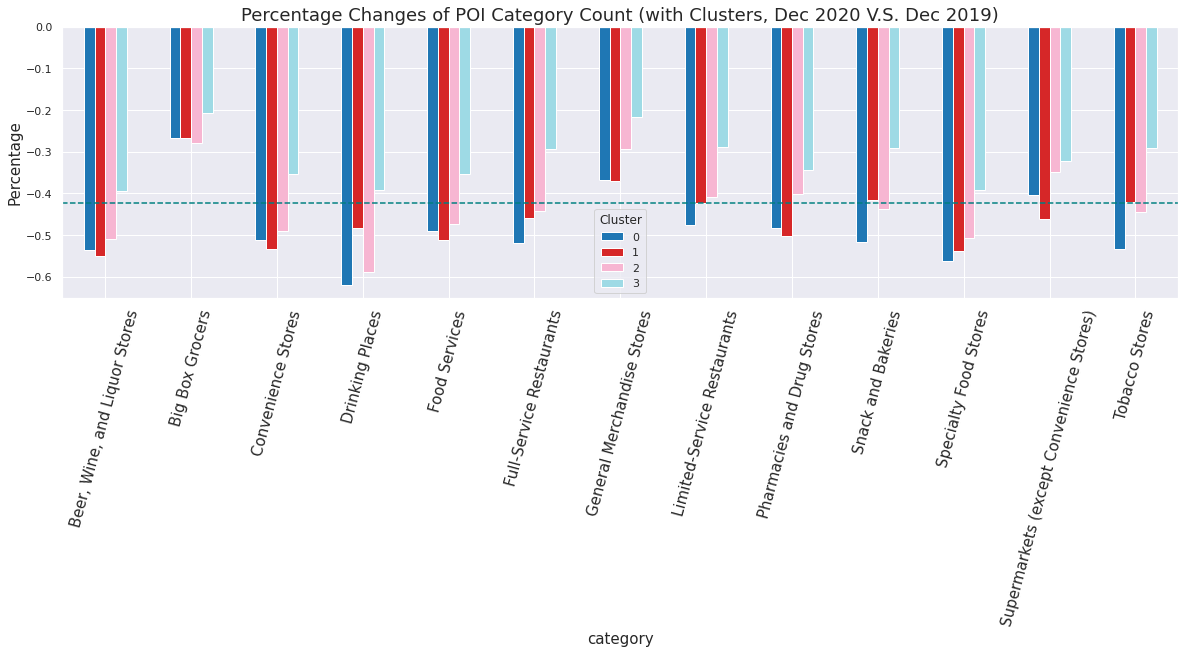

In [142]:
cateChange.T.plot.bar(figsize=(20, 5), cmap='tab20')
plt.axhline(y=cateChange.mean().mean(), color='teal', linestyle='--')
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of POI Category Count (with Clusters, Dec 2020 V.S. Dec 2019)')
plt.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

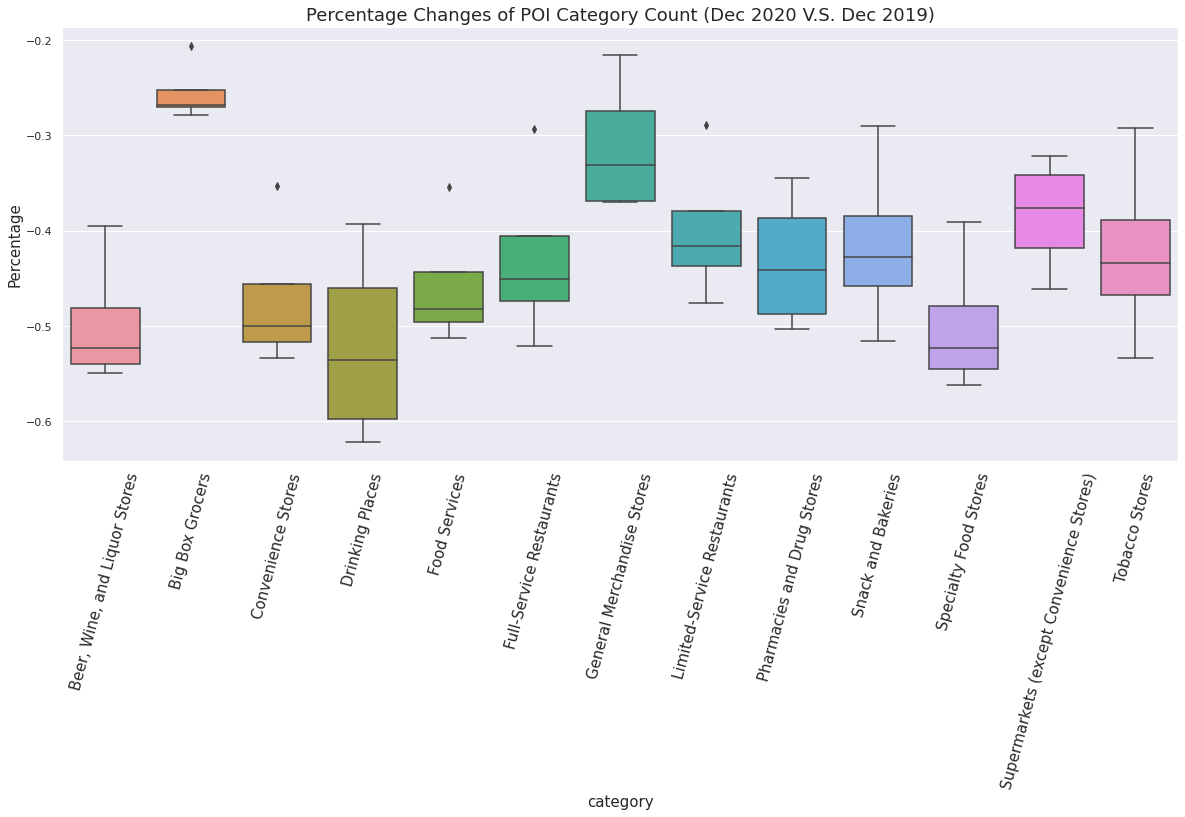

In [143]:
sns.boxplot(data=cateChange)
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of POI Category Count (Dec 2020 V.S. Dec 2019)')
plt.ylabel('Percentage')

### Visitor Count Changes

In [116]:
def get_pivot_table(trips, value_name):
    beforeCov = trips[trips.date_range_start<pd.to_datetime('2020-03-22 00:00:00-00:00')]
    beforeCov = beforeCov[['Cluster', 'category', value_name]]
    beforeCov = beforeCov.groupby(['Cluster', 'category'], as_index=False).median()
    beforeCov = pd.pivot_table(beforeCov, values=value_name, index=['Cluster'], columns=['category'])

    afterCov = trips[trips.date_range_start>=pd.to_datetime('2020-03-22 00:00:00-00:00')]
    afterCov = afterCov[['Cluster', 'category', value_name]]
    afterCov = afterCov.groupby(['Cluster', 'category'], as_index=False).median()
    afterCov = pd.pivot_table(afterCov, values=value_name, index=['Cluster'], columns=['category'])

    Change = (afterCov-beforeCov)/beforeCov
    return Change

In [146]:
evcChange = get_pivot_table(trips, 'estimated_visitor_count')
evcChange.head()

category,"Beer, Wine, and Liquor Stores",Big Box Grocers,Convenience Stores,Drinking Places,Food Services,Full-Service Restaurants,General Merchandise Stores,Limited-Service Restaurants,Pharmacies and Drug Stores,Snack and Bakeries,Specialty Food Stores,Supermarkets (except Convenience Stores),Tobacco Stores
Cluster,,,,,,,,,,,,,
0,0.586197,0.597521,0.580580,0.620013,0.574109,0.583322,0.556150,0.565512,0.568795,0.597497,0.574360,0.559714,0.579805
1,0.443236,0.284962,0.428080,0.687747,0.529477,0.509253,0.400143,0.431425,0.379496,0.488552,0.355721,0.439166,0.334394
2,0.632984,0.655730,0.634221,0.656867,0.658072,0.639979,0.608339,0.631314,0.643789,0.633372,0.619409,0.634497,0.651540
3,0.241566,0.220170,0.259902,0.283920,0.273032,0.259888,0.248485,0.247741,0.240714,0.241790,0.224770,0.249371,0.228278


Text(0, 0.5, 'Percentage')

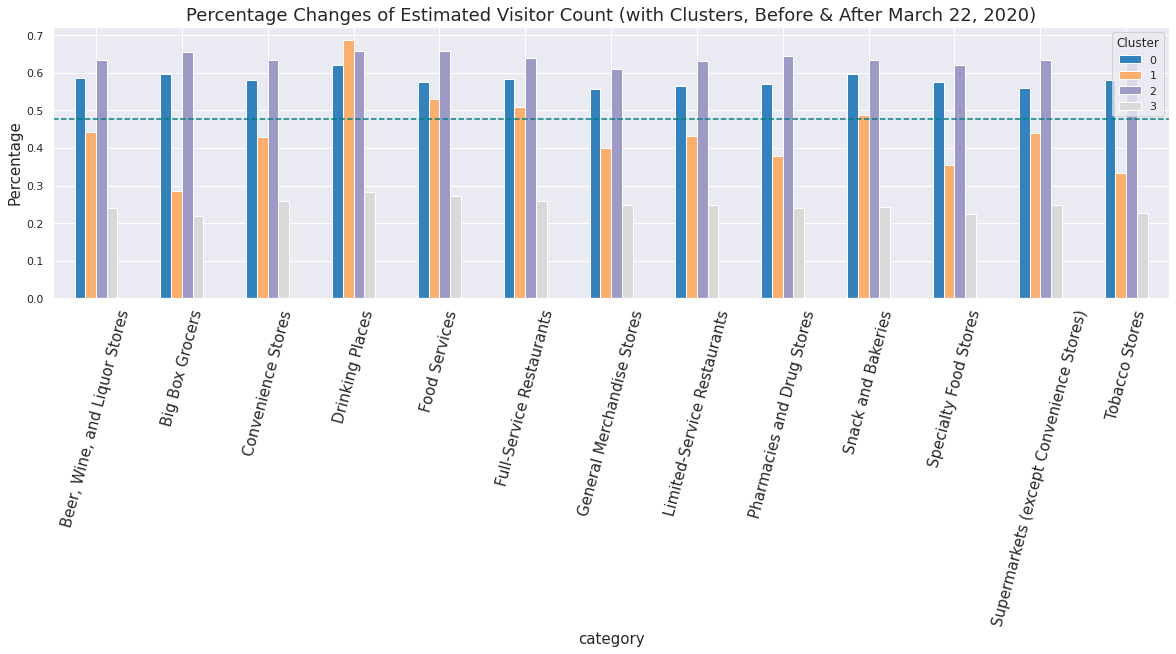

In [147]:
evcChange.T.plot.bar(figsize=(20, 5), cmap='tab20c')
plt.axhline(y=evcChange.mean().mean(), color='teal', linestyle='--')
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of Estimated Visitor Count (with Clusters, Before & After March 22, 2020)')
plt.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

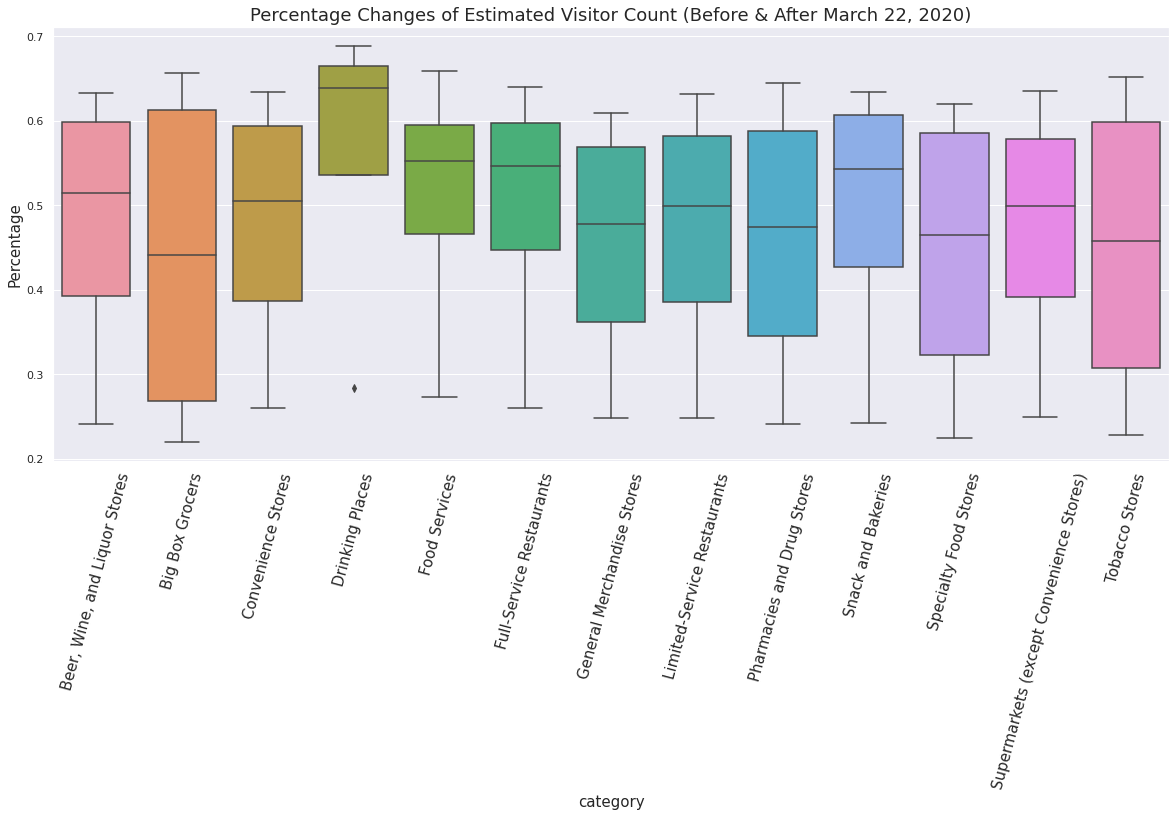

In [148]:
sns.boxplot(data=evcChange)
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of Estimated Visitor Count (Before & After March 22, 2020)')
plt.ylabel('Percentage')

In [149]:
pevcChange = get_pivot_table(trips, 'pct_estimated_visitor_count')
pevcChange.head()

category,"Beer, Wine, and Liquor Stores",Big Box Grocers,Convenience Stores,Drinking Places,Food Services,Full-Service Restaurants,General Merchandise Stores,Limited-Service Restaurants,Pharmacies and Drug Stores,Snack and Bakeries,Specialty Food Stores,Supermarkets (except Convenience Stores),Tobacco Stores
Cluster,,,,,,,,,,,,,
0,1.101695,1.074380,1.082645,1.162393,1.103448,1.094595,1.063866,1.084034,1.093220,1.105556,1.081967,1.123894,1.067797
1,1.212121,0.856000,1.210000,1.650000,1.494382,1.351064,1.115385,1.218421,1.144231,1.291667,1.117012,1.260870,1.017391
2,1.093023,1.111111,1.068702,1.124031,1.119841,1.119048,1.079365,1.093750,1.128000,1.098446,1.104839,1.123967,1.129032
3,0.912329,0.750000,0.897959,0.937500,0.900662,0.904110,0.901408,0.885906,0.909091,0.885135,0.891156,0.969925,0.849673


Text(0, 0.5, 'Percentage')

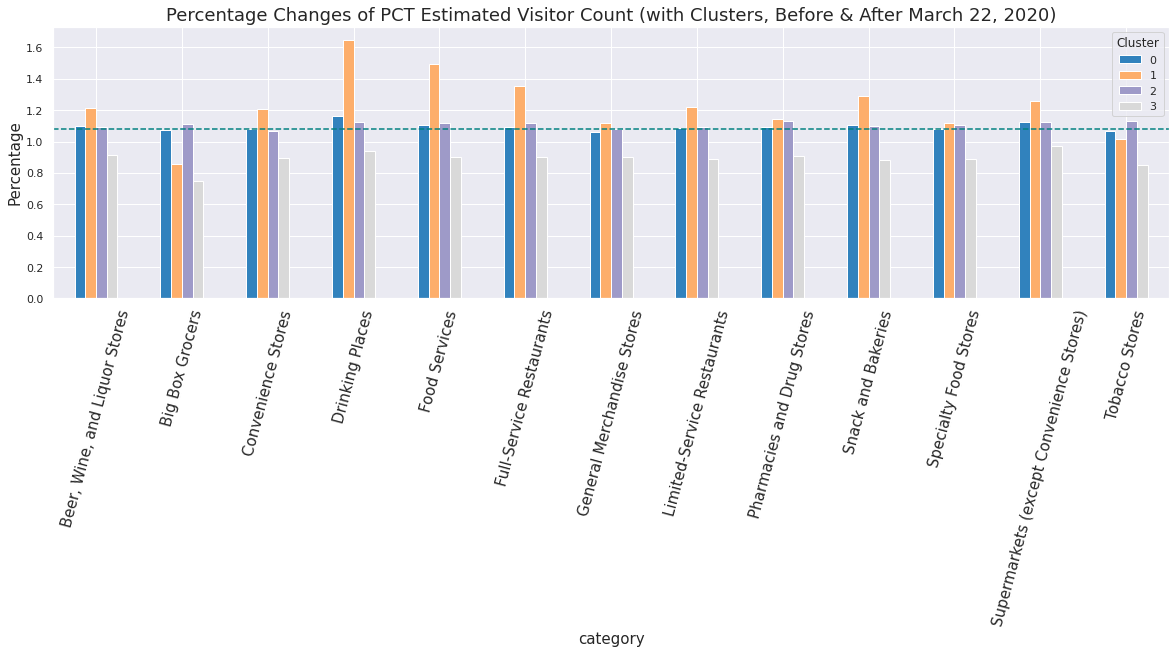

In [153]:
pevcChange.T.plot.bar(figsize=(20, 5), cmap='tab20c')
plt.axhline(y=pevcChange.mean().mean(), color='teal', linestyle='--')
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of PCT Estimated Visitor Count (with Clusters, Before & After March 22, 2020)')
plt.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

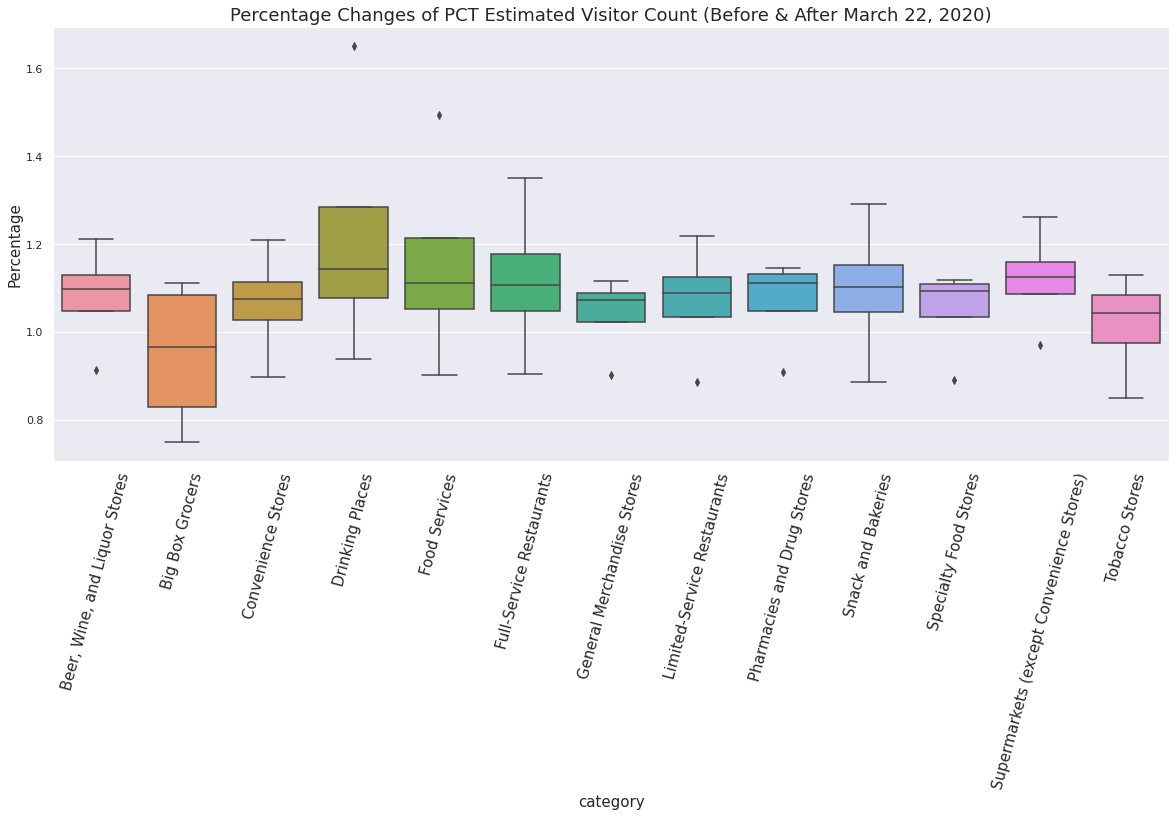

In [154]:
sns.boxplot(data=pevcChange)
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of PCT Estimated Visitor Count (Before & After March 22, 2020)')
plt.ylabel('Percentage')

In [ ]:
# former data

In [131]:
evctChange = get_pivot_table(trips, 'estimated_visitor_count_total')
evctChange.head()

category,"Beer, Wine, and Liquor Stores",Big Box Grocers,Convenience Stores,Drinking Places,Food Services,Full-Service Restaurants,General Merchandise Stores,Limited-Service Restaurants,Pharmacies and Drug Stores,Snack and Bakeries,Specialty Food Stores,Supermarkets (except Convenience Stores),Tobacco Stores
Cluster,,,,,,,,,,,,,
0,-0.248570,-0.242022,-0.232363,-0.248253,-0.247426,-0.248216,-0.253145,-0.253059,-0.257405,-0.245702,-0.242235,-0.265367,-0.246581
1,-0.356588,-0.320300,-0.367507,-0.382793,-0.393032,-0.374483,-0.360957,-0.366435,-0.371240,-0.369610,-0.361293,-0.385877,-0.339152
2,-0.229417,-0.217381,-0.216424,-0.220284,-0.217356,-0.227049,-0.232522,-0.223321,-0.229565,-0.224769,-0.222466,-0.235174,-0.223306
3,-0.355765,-0.307591,-0.333040,-0.336079,-0.327296,-0.343585,-0.347770,-0.338267,-0.357232,-0.341793,-0.352570,-0.368635,-0.336577


Text(0, 0.5, 'Percentage')

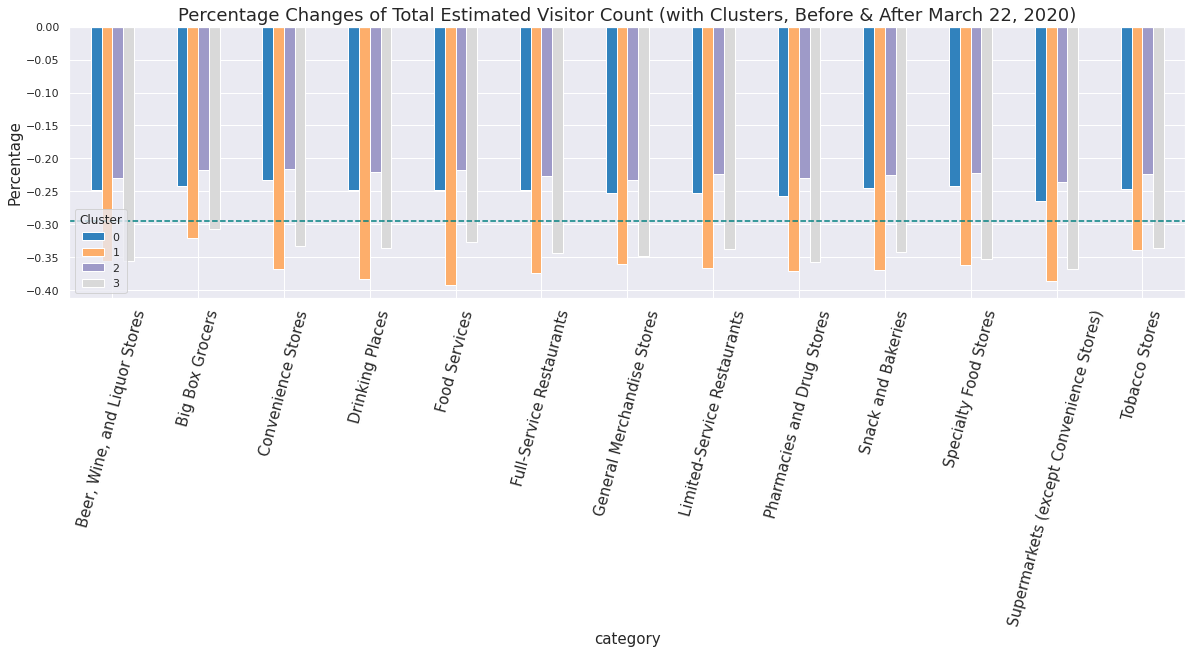

In [132]:
evctChange.T.plot.bar(figsize=(20, 5), cmap='tab20c')
plt.axhline(y=evctChange.mean().mean(), color='teal', linestyle='--')
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of Total Estimated Visitor Count (with Clusters, Before & After March 22, 2020)')
plt.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

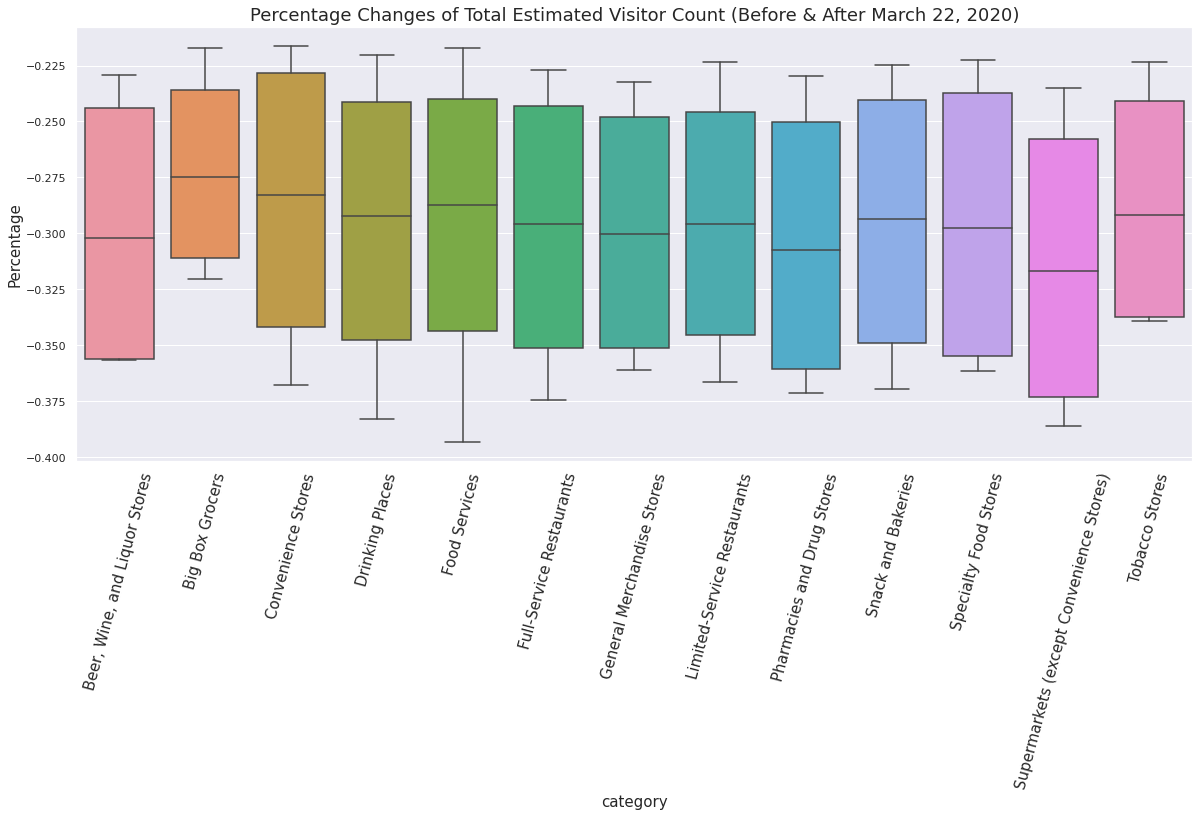

In [155]:
sns.boxplot(data=evctChange)
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of Total Estimated Visitor Count (Before & After March 22, 2020)')
plt.ylabel('Percentage')

In [134]:
vcChange = get_pivot_table(trips, 'visitor_count') # all values are 4
vcChange 

category,"Beer, Wine, and Liquor Stores",Big Box Grocers,Convenience Stores,Drinking Places,Food Services,Full-Service Restaurants,General Merchandise Stores,Limited-Service Restaurants,Pharmacies and Drug Stores,Snack and Bakeries,Specialty Food Stores,Supermarkets (except Convenience Stores),Tobacco Stores
Cluster,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
vctChange = get_pivot_table(trips, 'visitor_count_total')
vctChange 

category,"Beer, Wine, and Liquor Stores",Big Box Grocers,Convenience Stores,Drinking Places,Food Services,Full-Service Restaurants,General Merchandise Stores,Limited-Service Restaurants,Pharmacies and Drug Stores,Snack and Bakeries,Specialty Food Stores,Supermarkets (except Convenience Stores),Tobacco Stores
Cluster,,,,,,,,,,,,,
0,-0.527132,-0.524345,-0.524904,-0.538462,-0.531496,-0.527132,-0.521236,-0.525097,-0.527132,-0.530534,-0.522901,-0.531250,-0.517928
1,-0.539130,-0.453125,-0.551724,-0.625571,-0.604348,-0.576419,-0.531915,-0.551282,-0.536170,-0.565217,-0.524590,-0.558559,-0.508333
2,-0.528369,-0.530466,-0.524648,-0.530249,-0.532374,-0.530466,-0.528571,-0.525000,-0.532374,-0.528571,-0.527675,-0.534545,-0.536496
3,-0.479452,-0.431894,-0.477663,-0.489583,-0.478114,-0.479310,-0.474227,-0.472789,-0.480836,-0.470790,-0.470790,-0.494662,-0.462585


Text(0, 0.5, 'Percentage')

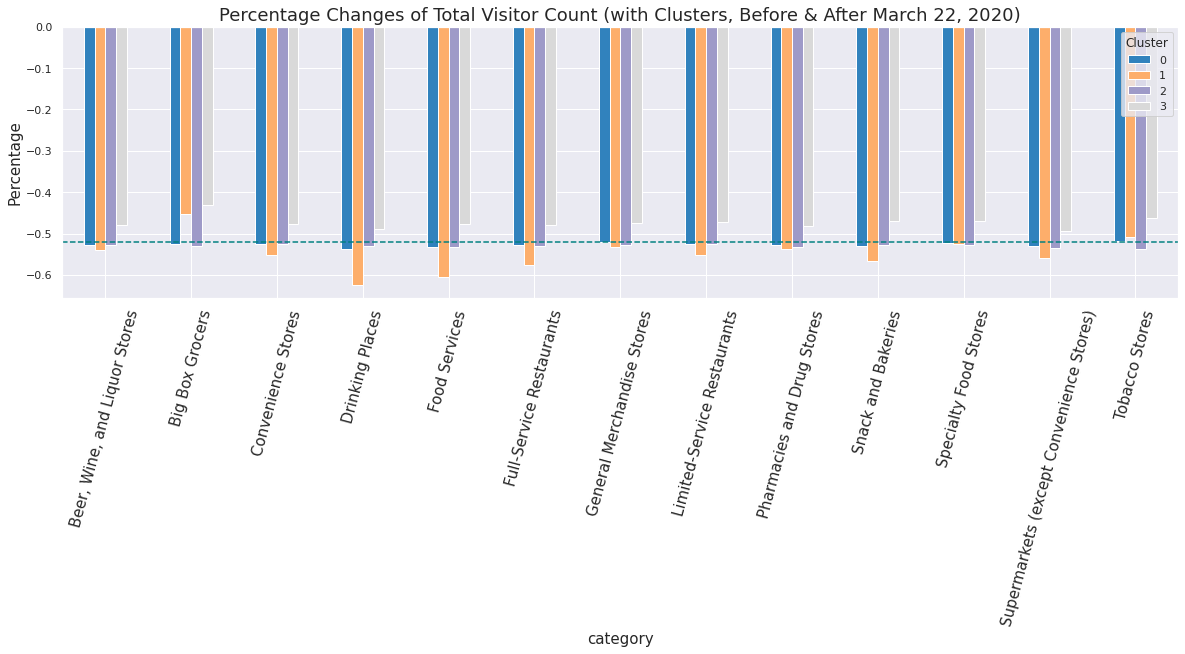

In [123]:
vctChange.T.plot.bar(figsize=(20, 5), cmap='tab20c')
plt.axhline(y=vctChange.mean().mean(), color='teal', linestyle='--')
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of Total Visitor Count (with Clusters, Before & After March 22, 2020)')
plt.ylabel('Percentage')

Text(0, 0.5, 'Percentage')

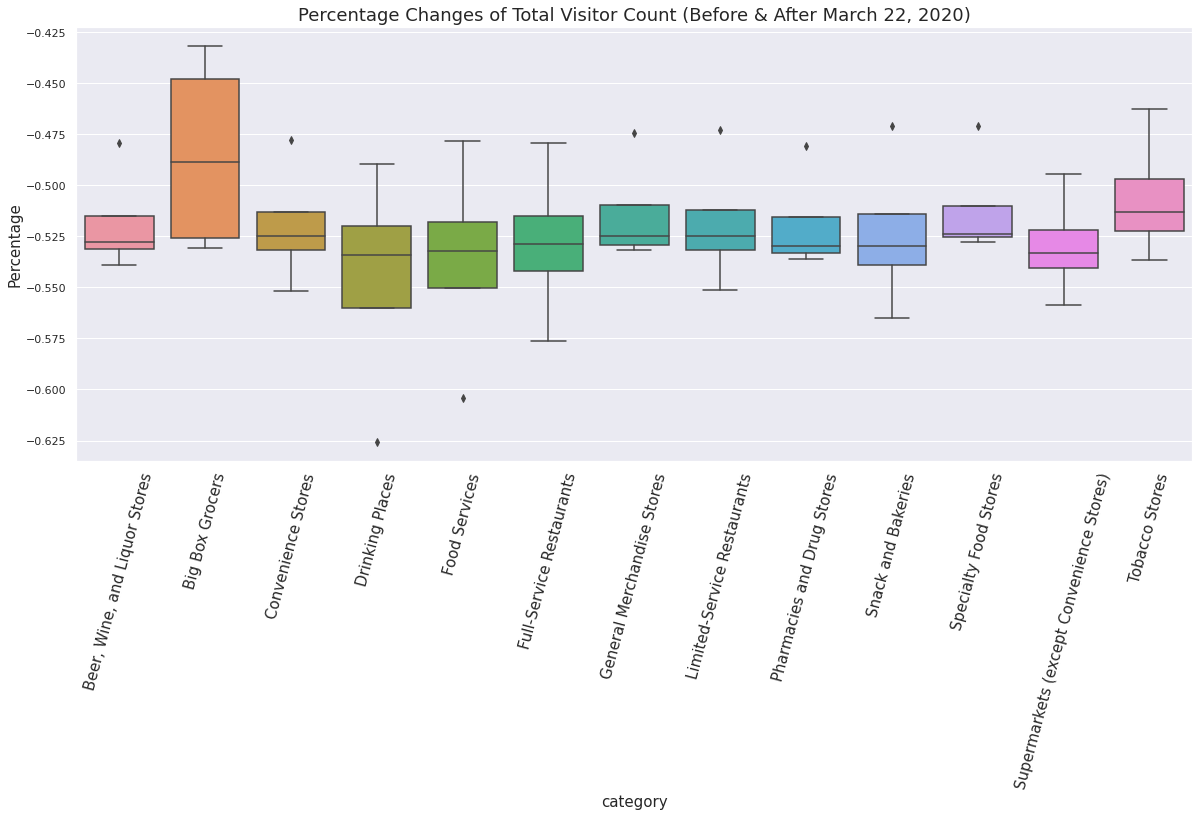

In [124]:
sns.boxplot(data=vctChange)
plt.xticks(fontsize=15, rotation=75)
plt.title('Percentage Changes of Total Visitor Count (Before & After March 22, 2020)')
plt.ylabel('Percentage')

### Time-series /Cluster /Category

In [224]:
tp19 = trip2019[['date', 'estimated_visitor_count', 'category', 'Cluster']]
tp19['date'] = pd.to_datetime(tp19['date'])
tp19['date'] = tp19['date'].dt.strftime('%m-%d')
tp19 = tp19.groupby(['category', 'Cluster', 'date'], as_index=False).median()
tp19 = pd.pivot_table(tp19, values='estimated_visitor_count', index=['date'], columns=['category', 'Cluster'])
tp19.head()

category Beer, Wine, and Liquor Stores                                 \
Cluster                              0          1         2         3   
date                                                                    
01-07                         7.211499  10.146965  7.395122  9.044872   
01-14                         7.577640  10.311301  7.234321  9.115282   
01-21                         7.692308  10.646918  7.788136  9.146865   
01-28                         7.627447  10.710526  7.645995  9.362346   
02-04                         7.827068  10.567063  7.858930  9.480000   

category Big Box Grocers                                Convenience Stores  \
Cluster                0          1         2         3                  0   
date                                                                         
01-07           7.548380  10.369287  7.382685  9.212698           7.267380   
01-14           7.521520  10.496261  7.543704  9.270045           7.137725   
01-21           7.770701  10.646918  7.672756  9.353666           7.231467   
01-28           7.763033  10.543974  7.868132  9.462963           7.573485   
02-04           7.944086  10.881226  7.852427  9.591398           7.611054   

category             ... Specialty Food Stores            \
Cluster           1  ...                     2         3   
date                 ...                                   
01-07     10.238095  ...              7.223970  8.888889   
01-14     10.498113  ...              7.420054  8.938330   
01-21     10.423913  ...              7.512821  9.048975   
01-28     10.389722  ...              7.720406  9.137558   
02-04     10.265714  ...              7.986262  9.252730   

category Supermarkets (except Convenience Stores)                       \
Cluster                                         0          1         2   
date                                                                     
01-07                                    7.299647  10.466886  7.445407   
01-14                                    7.352381  10.681223  7.507917   
01-21                                    7.482353  10.934169  7.575893   
01-28                                    7.749066  10.792554  7.959146   
02-04                                    7.861592  10.729858  7.852427   

category           Tobacco Stores                                 
Cluster          3              0          1         2         3  
date                                                              
01-07     9.186606       7.076412  10.252086  7.619195  8.869070  
01-14     9.297468       7.339088  10.171500  7.612233  9.044396  
01-21     9.426968       7.432679  10.472222  7.646051  8.953975  
01-28     9.526718       7.657798  10.891496  8.104080  9.182363  
02-04     9.624617       7.949886  10.873085  8.195718  8.838852  

[5 rows x 52 columns]

In [226]:
tp20 = trip2020[['date', 'estimated_visitor_count', 'category', 'Cluster']]
tp20['date'] = pd.to_datetime(tp20['date'])
tp20['date'] = tp20['date'].dt.strftime('%m-%d')
tp20 = tp20.groupby(['category', 'Cluster', 'date'], as_index=False).median()
tp20 = pd.pivot_table(tp20, values='estimated_visitor_count', index=['date'], columns=['category', 'Cluster'])
tp20.head()

category Beer, Wine, and Liquor Stores                                   \
Cluster                              0          1          2          3   
date                                                                      
01-06                        12.135231  13.449591  13.393382  11.182962   
01-13                        13.757252  15.719439  14.922861  12.065268   
01-20                        13.951893  15.350157  15.060606  12.315098   
01-27                        12.216216  14.603878  12.978495  11.389978   
02-03                        11.284091  13.027237  11.408829  10.583732   

category Big Box Grocers                                  Convenience Stores  \
Cluster                0          1          2          3                  0   
date                                                                           
01-06          12.386617  12.996016  13.433600  11.324397          11.779310   
01-13          13.757252  15.126685  14.393235  11.949606          13.108014   
01-20          14.020408  14.381793  14.604317  12.216949          13.470405   
01-27          12.474886  13.935813  13.085714  11.459873          11.890196   
02-03          11.284091  13.313953  11.630279  10.709381          11.022654   

category             ... Specialty Food Stores             \
Cluster           1  ...                     2          3   
date                 ...                                    
01-06     13.213720  ...             13.432990  11.190570   
01-13     15.748428  ...             15.031785  12.085349   
01-20     15.334476  ...             14.863813  12.089136   
01-27     14.677442  ...             13.367347  11.361894   
02-03     13.534884  ...             11.815603  10.265664   

category Supermarkets (except Convenience Stores)                        \
Cluster                                         0          1          2   
date                                                                      
01-06                                   12.479448  13.980612  13.706161   
01-13                                   13.546895  15.853861  15.137724   
01-20                                   13.776908  16.047510  15.492308   
01-27                                   12.201207  15.241935  13.342541   
02-03                                   11.352113  13.979716  11.687253   

category            Tobacco Stores                                   
Cluster           3              0          1          2          3  
date                                                                 
01-06     11.636364      11.972096  13.511209  13.739394  11.256281  
01-13     12.495114      13.611035  15.507042  15.740891  11.839599  
01-20     12.793177      13.241050  15.442177  15.066667  11.928889  
01-27     11.777778      12.187517  13.050634  13.313559  11.050847  
02-03     10.849095      11.317829  12.926179  11.819634  10.218430  

[5 rows x 52 columns]

In [175]:
len(tp19.category.unique())

13

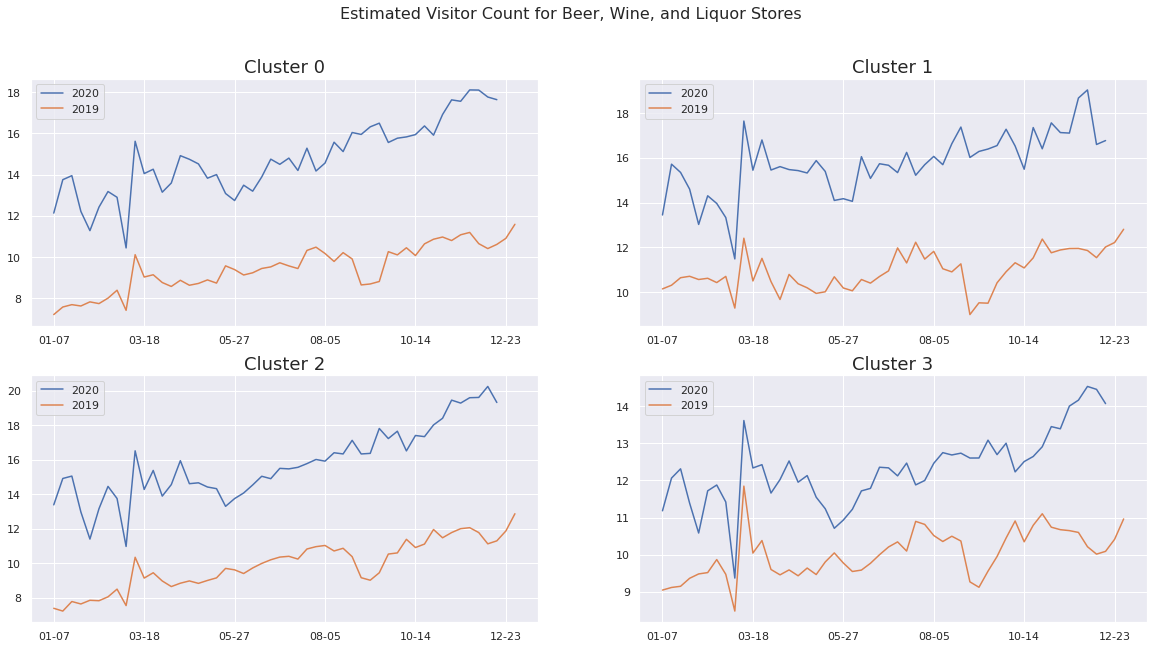

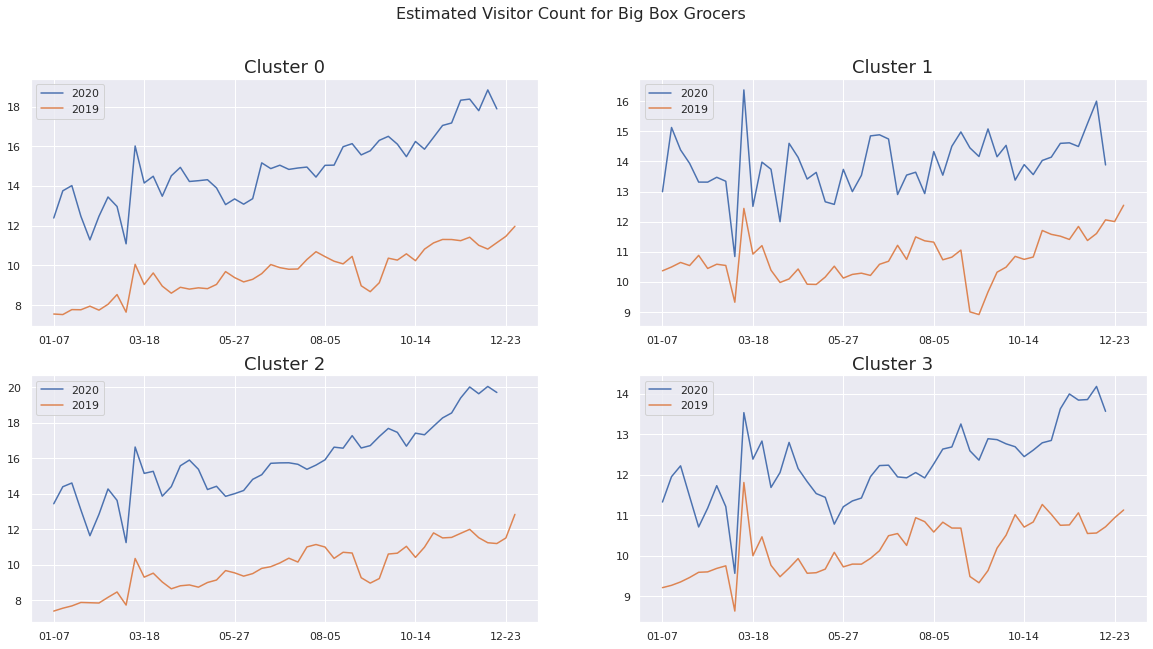

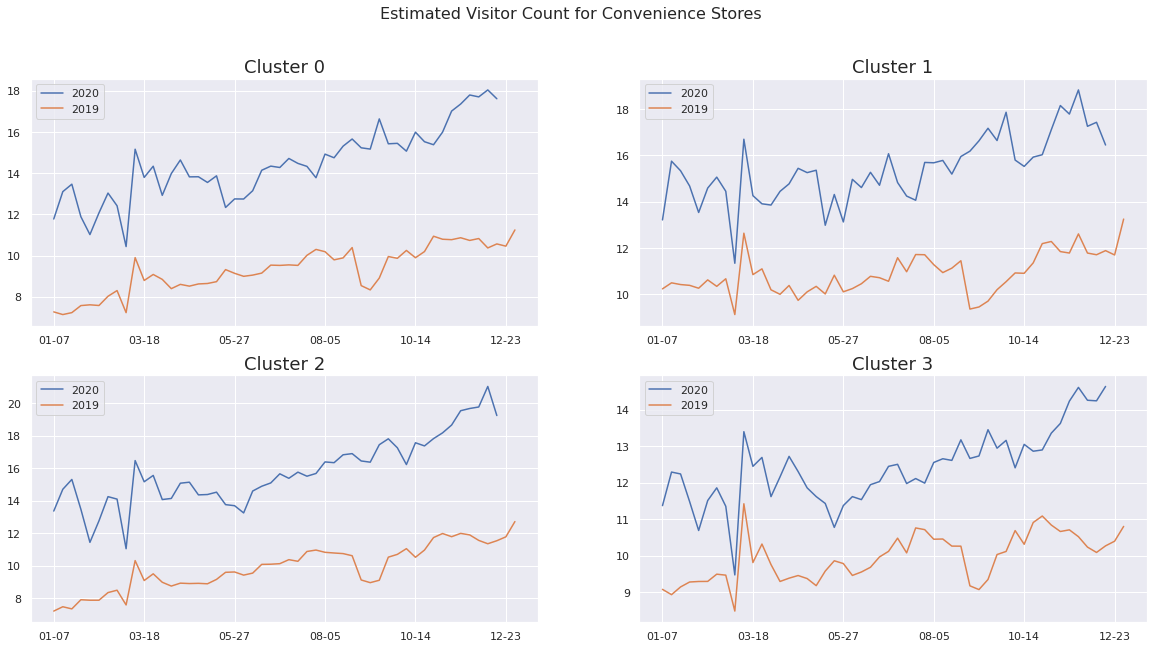

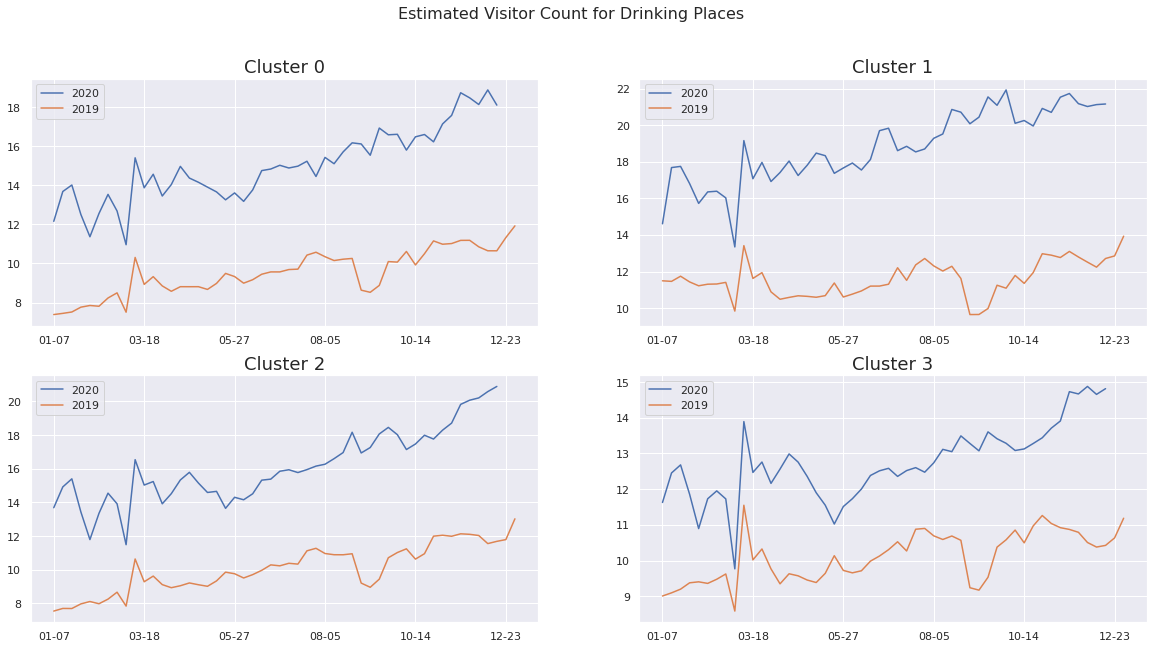

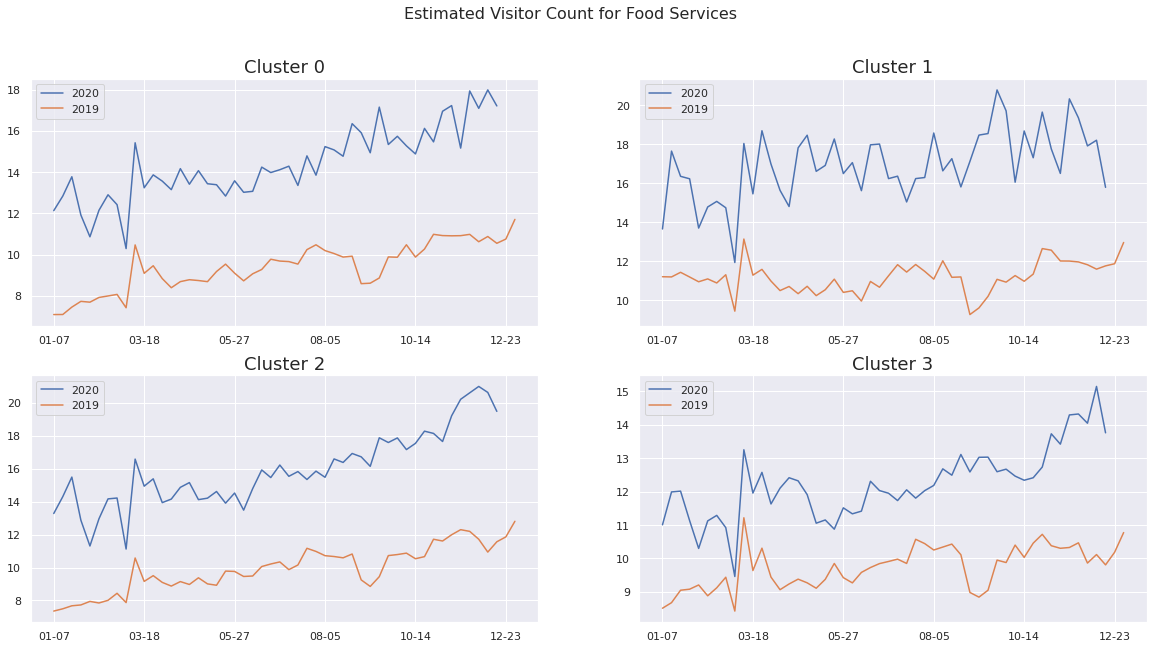

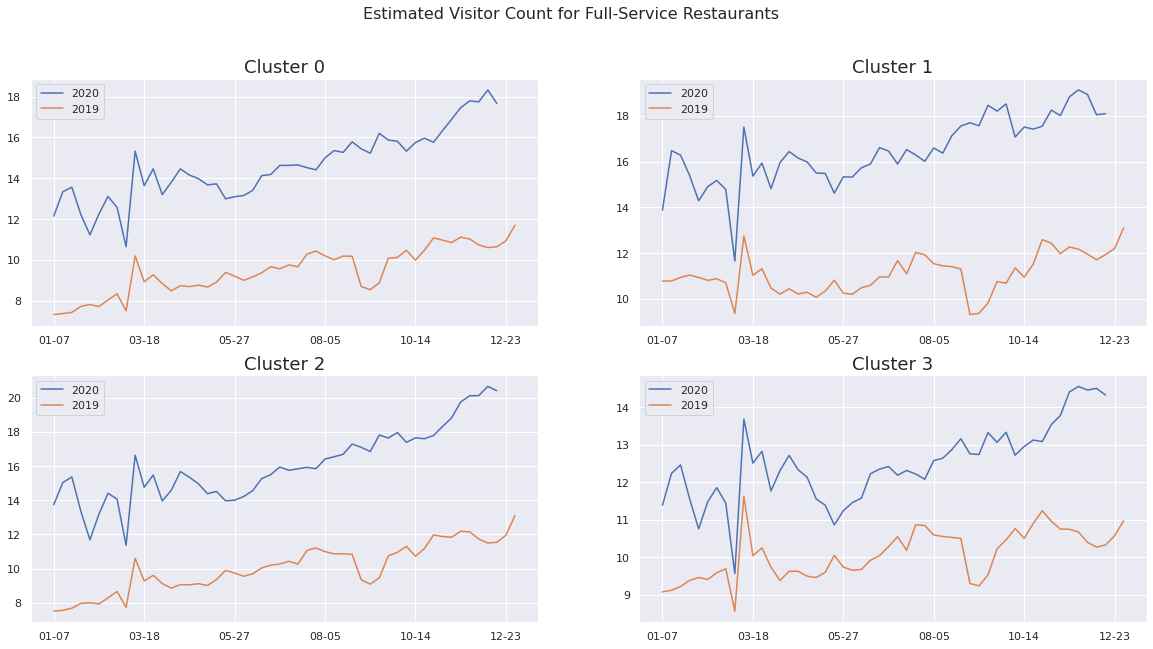

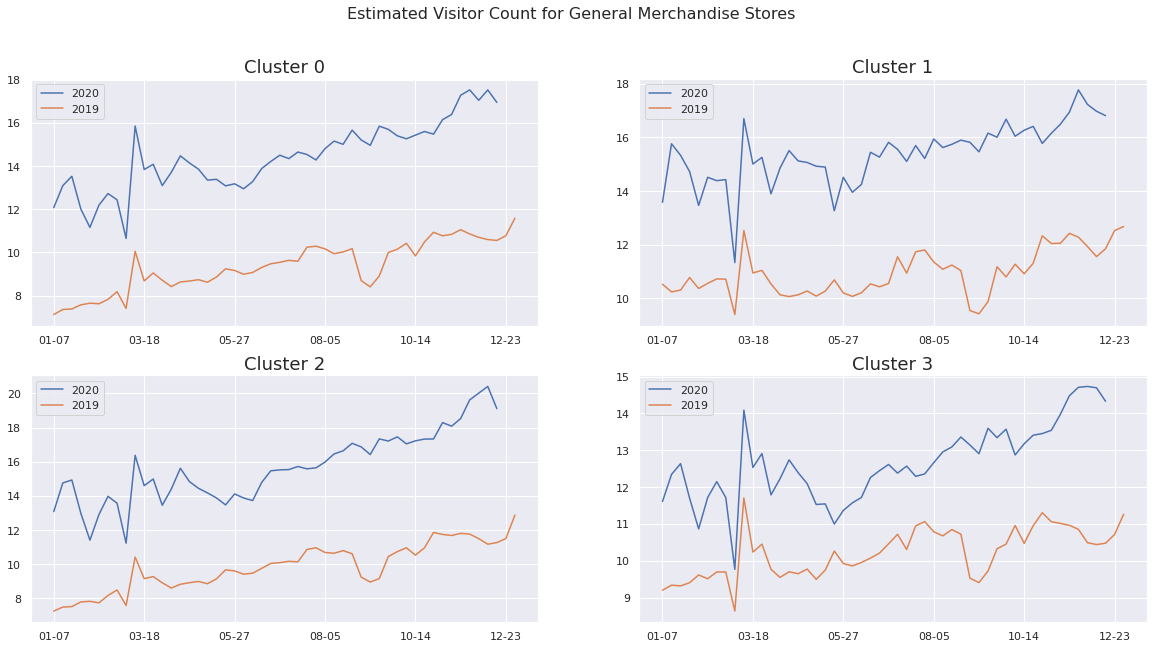

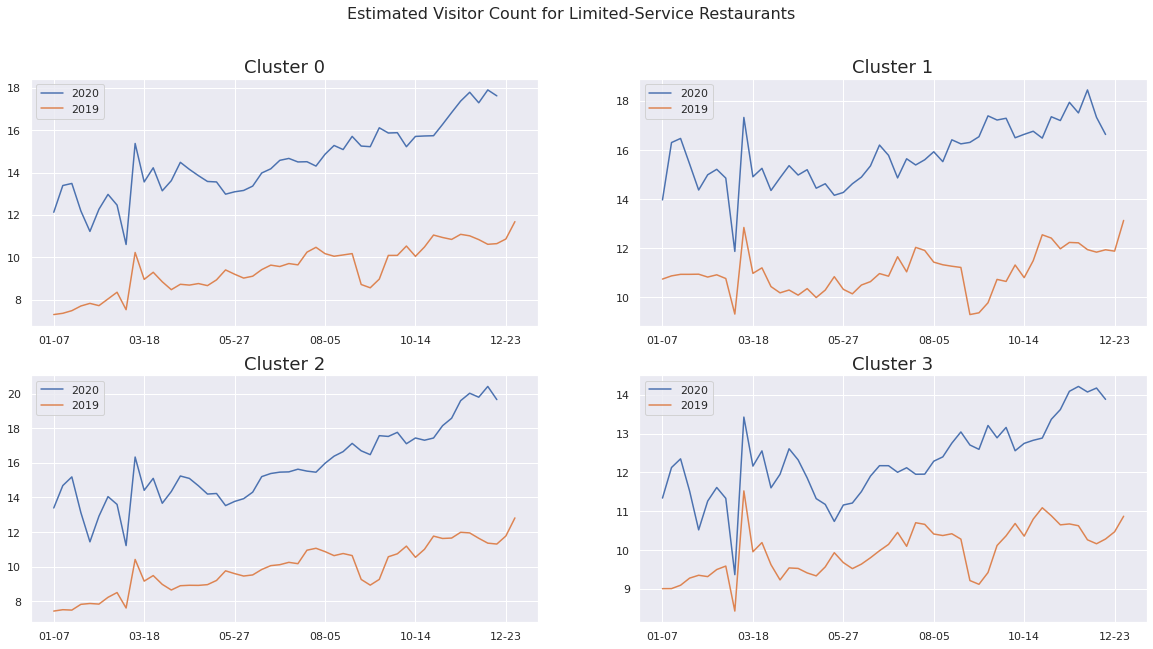

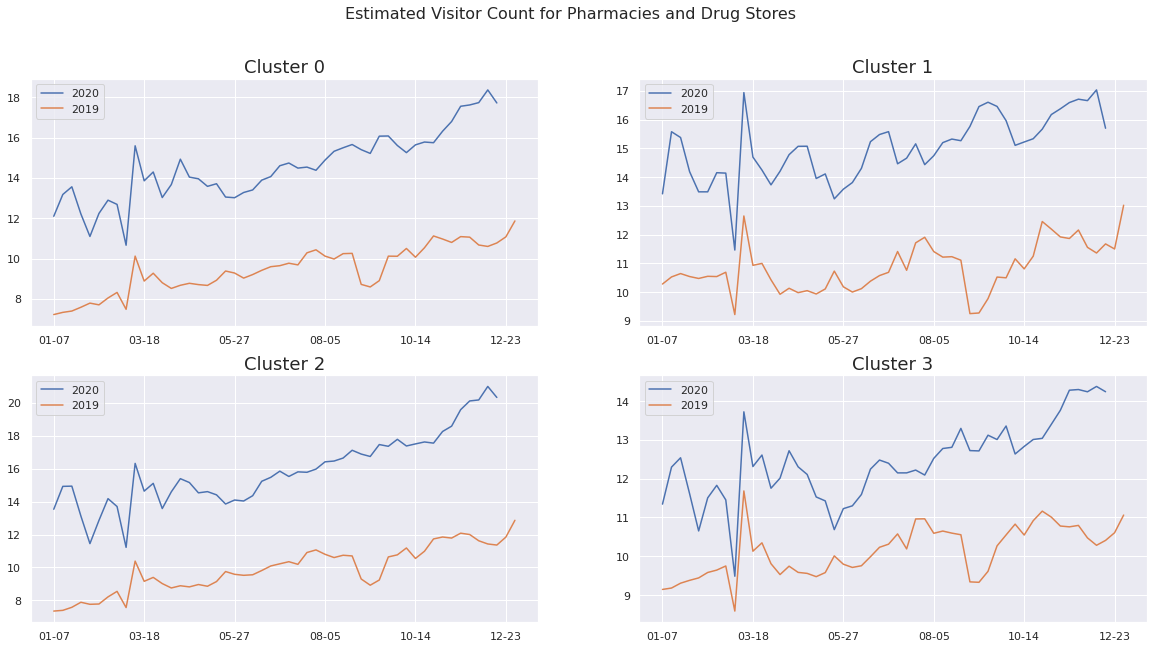

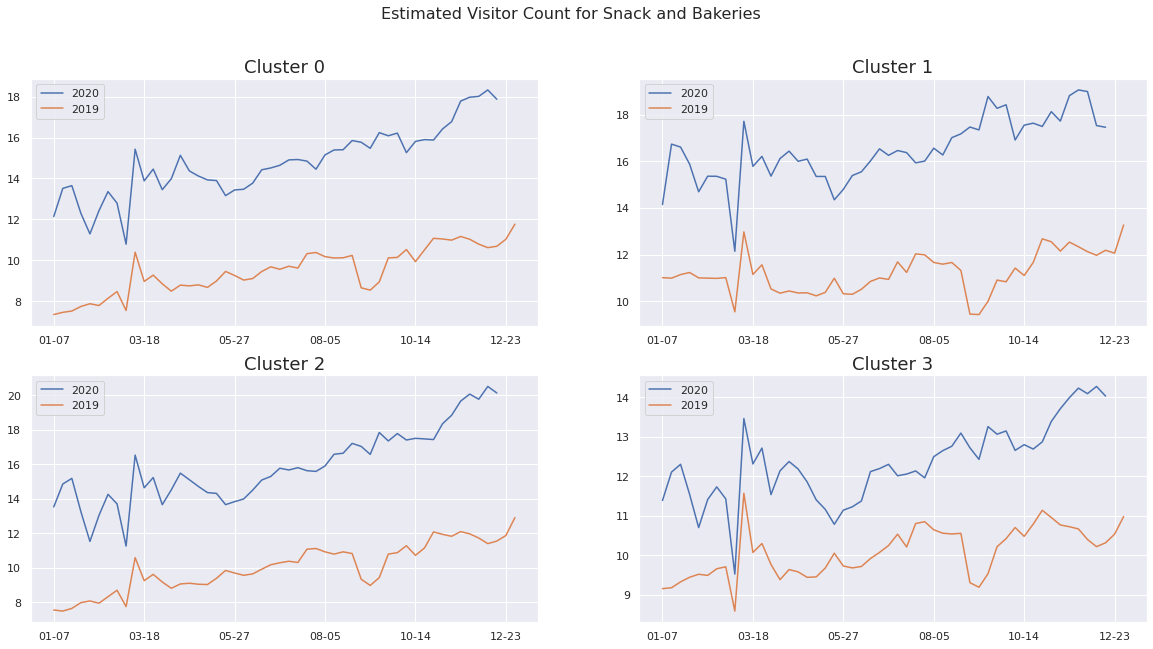

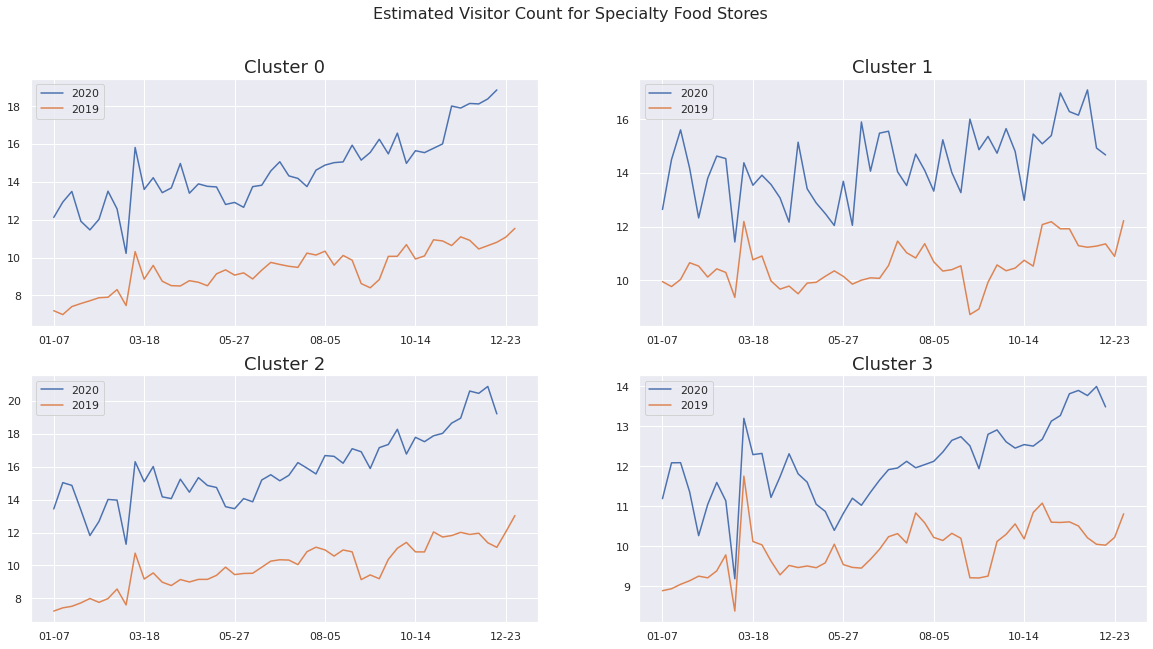

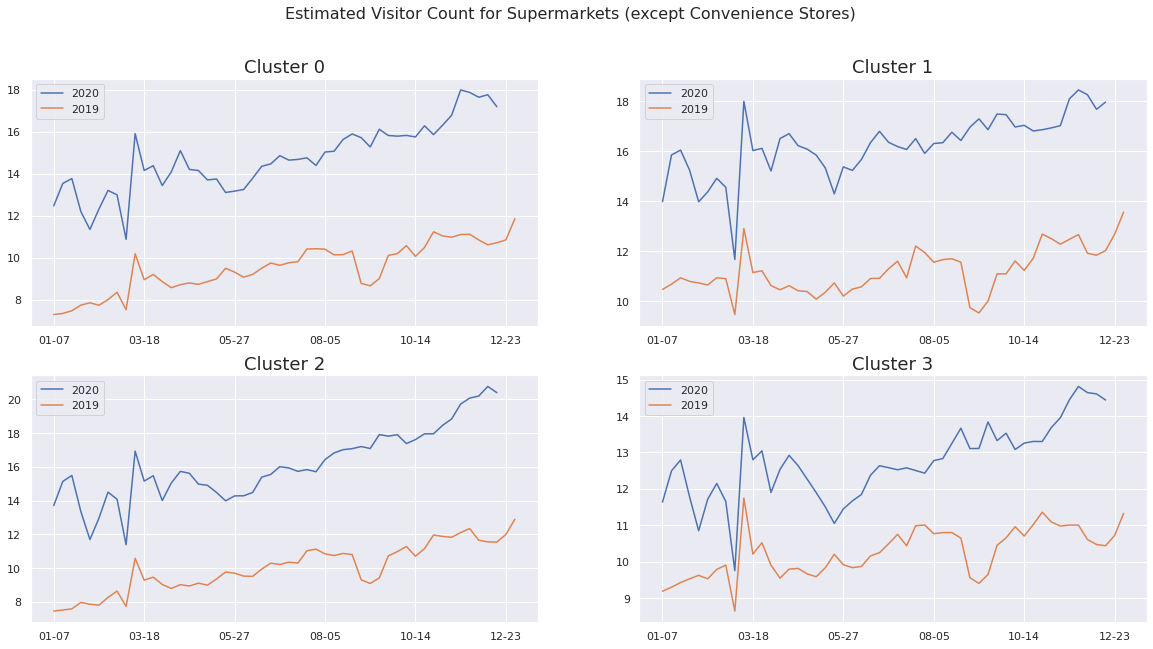

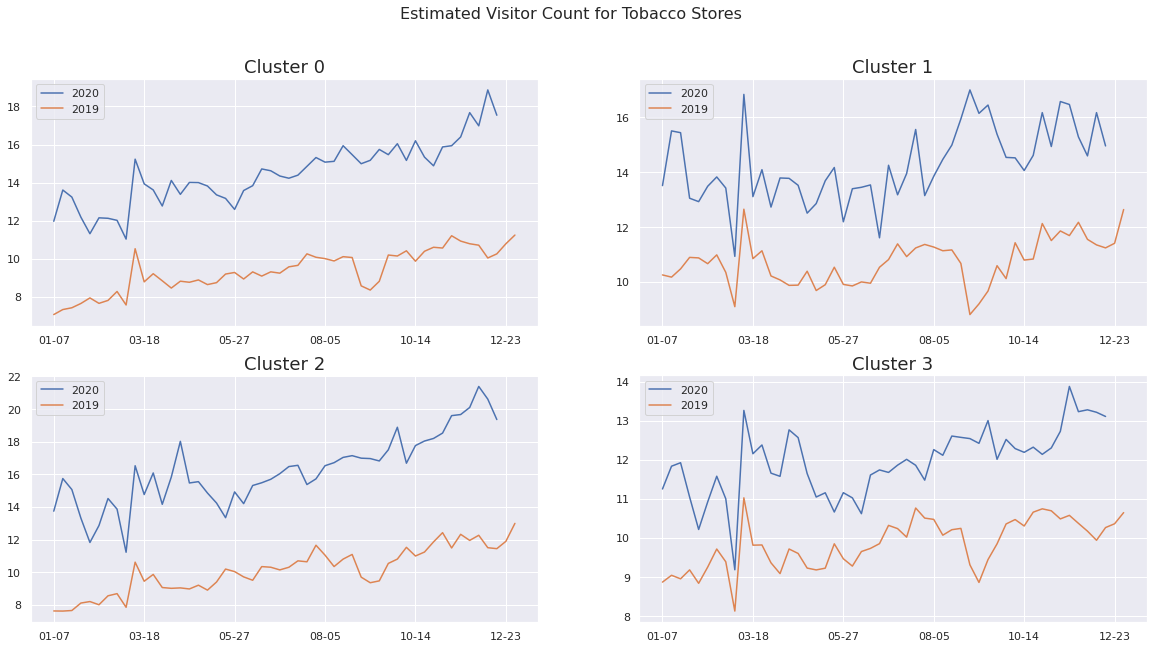

In [252]:
for n, i in enumerate(tp20.columns):
    if (n-1)//4 != n//4:
        fig, axes = plt.subplots(2,2,figsize=(20,10))
        fig.suptitle('Estimated Visitor Count for %s' % i[0], fontsize=16)
        ax = axes.ravel()
    cl = n%4
    tp20[i].plot(ax=ax[cl], label='2020', legend=True)
    tp19[i].plot(ax=ax[cl], label='2019', legend=True)
    ax[cl].set(xlabel=None, title='Cluster %d' % cl)